In [22]:
%autosave 0

Autosave disabled


# How to get a dense enough squares on a sphere?
- Just tile all of the squares you want and take out which you don't want. In this tutorial, I will try the squares on the equators
- Some good choices which I would like to try in the other scripts
    - Geodesic Grid (not squares, but absolutely equal area equal shape) ![](https://upload.wikimedia.org/wikipedia/commons/7/77/Conway_dccccD.png)
    - Quadrilateralized spherical cube ![](https://camo.githubusercontent.com/e64955b3cc2a25d031eda44a9221ec06fc698ad5/68747470733a2f2f7261772e6769746875622e636f6d2f6369782f517561645370686572652f6d61737465722f6578616d706c65732f7370686572652e706e67)
    - (not square) one of the good choice is to divide in longitude, and only one cut in equator for latitude.

# Preparing the overlapped patches in Layers

make sure you can import all modules

In [1]:
import numpy as np
import seaborn as sns # a plotting package, not necessary
import matplotlib
import matplotlib.pyplot as plt
import healpy as hp
from mifipy import mfun, Yakitori
import sys
cmap1 = matplotlib.colors.ListedColormap(sns.color_palette("GnBu_d", n_colors=20))

%matplotlib inline

In [3]:
def Good_Scheme_Scores(Addition_map):
    Sky_total = len(Addition_map)
    OverLap   = len(Addition_map[Addition_map >  1.])
    Coverage  = len(Addition_map[Addition_map != 0])    
    return (Coverage - OverLap) / Sky_total

- `Good_Scheme_Scores`: `(Coverage - OverLap) / Sky_total`,  
if there is no overlapping, the score means sky coverage (counting in healpix pixels)

/Users/cicero/anaconda/envs/snakes/lib/python3.5/site-packages/numpy/core/numeric.py:190: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  a = empty(shape, dtype, order)


Goodness of this Scheme is 0.731201171875


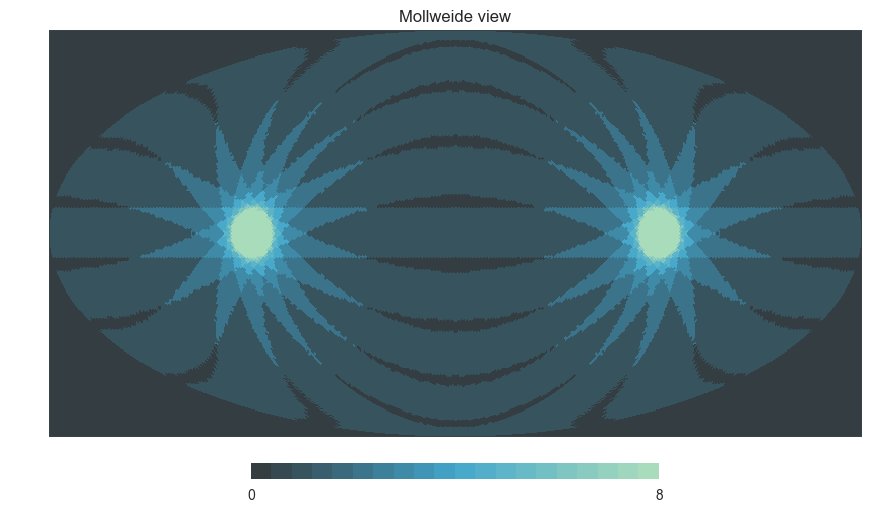

In [4]:
# be patient about this slow preparing 
MK = False
PHI_RANGE   = 18
THETA_RANGE = 22.5
NSIDE       = 64
PATCH_SIZE  = 100
period      = 180 // THETA_RANGE
Layers      = []
Theta_List  = np.arange(period) * THETA_RANGE

for theta in Theta_List:
    Layer = Yakitori.CartView_Block_Layer(theta, PHI_RANGE, 
                                          NSIDE, patch_size=PATCH_SIZE)     
    for A in Layer: Layers.append(A)
    del Layer

# make it numpy to speed up the looping in python
Layers       = np.array(Layers)
Addition_map = np.sum(Layers, axis=0)
hp.mollview(Addition_map, cmap=cmap1) # plot healpix in mollewide projection

print('Goodness of this Scheme is {}'.format(Good_Scheme_Scores(Addition_map)))

In [8]:
print('num_of_patches: {}; len_of_healpix_pixels: {}'.format(Layers.shape[0], Layers.shape[1]))

num_of_equators: 160; len_of_healpix_pixels: 49152


- `MK`: setting for mask (`True` or `False`), read by later decoding function
- `CartView_Block_Layer`: a function to pile patches into Layers on a equator in a specific `theta` degree rotation
- `Layers`: 2-D array, `Layers.shape = [num_of_patches, len_of_healpix_pixles]`
- `Addition_map`: 1-D array, sum of `Layers` in shape of `len_of_healpix_pixles`

These are some useful functions will be applied in taking out program. It may be a little bit un-readable.

In [9]:
def div(a,b): return b / a

def max_index(array): 
    # Use Yakitori to find where are peppers you don't want
    ## argmax -> maximum index in a ravel array; unravel-> return indexs in a given shape
    return np.unravel_index(array.argmax(), 
                            array.shape)

def Top_chart(Layers, Yakitori):
    # nonzero -> give the index of nonzero Layer
    ## maybe using map can shorten this lineee...
    return [Good_Scheme_Scores(np.sum(np.delete(Layers, i, axis=0), axis=0)) for i in np.nonzero(Yakitori)[0]]

def update_bread_score(Layers, theta_range, phi_range):
    thick  = len(Layers)
    num_patches_equator = int(180 // theta_range) # int for range
    period = 360 // phi_range
    Bread  = thick // num_patches_equator
    Bread_Sesame_List = []
    for i in range(num_patches_equator):
        Equator_Layer = Layers[Bread * i : Bread * ( i + 1 )]
        Bread_Sesame = [A.max() for A in Equator_Layer]
        
        # count number of patches in one rotated equator
        Bread_Score = np.sum(Bread_Sesame) / len(Bread_Sesame) 
        Bread_Sesame_List.append(Bread_Score)
    return Bread_Sesame_List

- `max_index`: return the index of maximum value in an array.
- `Top_chart`: return a list of Good_Scheme_Scores `for` taking out the each nonzero Layers in Yakitori list.
- `update_bread_score`: return a list of percentage of patches in each equators.
- `div`: a non-linear weighting I choose to weight the score in taking out program

Below is the main program:

In [13]:
def Yakitori_optimize(Layers, theta, phi, Mask=False, snap=True):
    Layers = Layers.copy() # copy to the other memory location
    
    # basic extraction 
    thick = len(Layers)
    Height_Element = 180 // theta
    period = 360 // phi
    
    # brute force while loop to get rid of all overlapping
    training_curve = []
    while True:
        Addition_map = np.sum(Layers, axis=0)
        
        # snap shot for ever steps
        if snap==True:
            hp.mollview(Addition_map, cmap=cmap1);
            plt.savefig(str(len(training_curve)) + '.png')
            plt.clf()
            
        # break if there are no overlapping
        overlapping  = len(Addition_map[Addition_map > 1.])
        if overlapping == 0:
            break
        del overlapping
                
        i = max_index(Addition_map)
        Yakitori = Layers[:, i] # values in each Layers

        # update bread score
        Bread_Sesame_List = update_bread_score(Layers, THETA_RANGE, PHI_RANGE)

        # We don't want Mask to be taken out, so give it a very large value
        if Mask==True:
            Bread_Sesame_List.append(9999.)
        
        # Get the list of Top_chart Scheme Scores
        # extract the Bread_Sesame_Scores: The score link to different Layers
        Good_Rotate_Scores = Top_chart(Layers, Yakitori)    
        Bad_Bread_Scores   = [Bread_Sesame_List[j] for j in np.nonzero(Yakitori)[0] // period]

        # multiply to weight the Seseame score & Good_Scheme_Score
        Good_Rotate_Scores = list(map(div, 
                                      Bad_Bread_Scores, Good_Rotate_Scores))
        
        # speed up the loop for multiple deleting Layers
        if np.sum(Yakitori) > 4:
            sort_Yakitori = [x for (y,x) in sorted(zip(Good_Rotate_Scores,
                                                       np.nonzero(Yakitori)[0]))]
            for j in sort_Yakitori[len(sort_Yakitori) // 2:]:
                Layers[j] = np.zeros(Layers[0].shape)
            sys.stdout.write("*")
            sys.stdout.flush()
                
        else:        
            sort_Yakitori = [x for (y,x) in sorted(zip(Good_Rotate_Scores, 
                                                       np.nonzero(Yakitori)[0]))]
            Layers[sort_Yakitori[-1]] = np.zeros(Layers[0].shape)
            sys.stdout.write(".")
            sys.stdout.flush()

        training_curve.append(Good_Scheme_Scores(Addition_map))

        del Good_Rotate_Scores, Yakitori, sort_Yakitori
    hp.mollview(Addition_map, cmap=cmap1)
    print('Good_Scheme_Scores is {}'.format(Good_Scheme_Scores(Addition_map)))
    return np.array(Layers), training_curve

Execute the function

****......................................................Good_Scheme_Scores is 0.7027791341145834


/Users/cicero/anaconda/envs/snakes/lib/python3.5/site-packages/numpy/core/numeric.py:190: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  a = empty(shape, dtype, order)


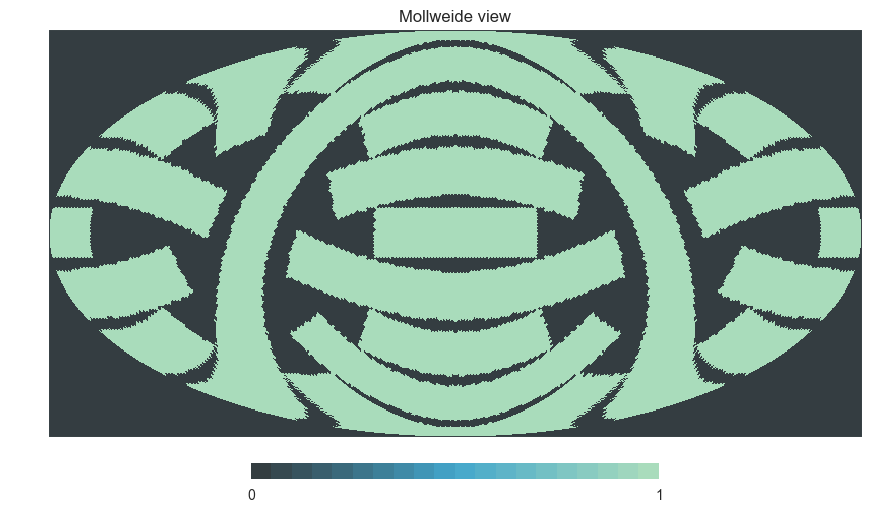

In [14]:
# Brute loop for optimization
opt_Layers, training_curve = Yakitori_optimize(Layers, THETA_RANGE, PHI_RANGE, Mask=MK, snap=False)

- `snap`: if true, then it will save all the snapshot image for every step in the default directory

Let's see the Good_Scheme_Score in every steps

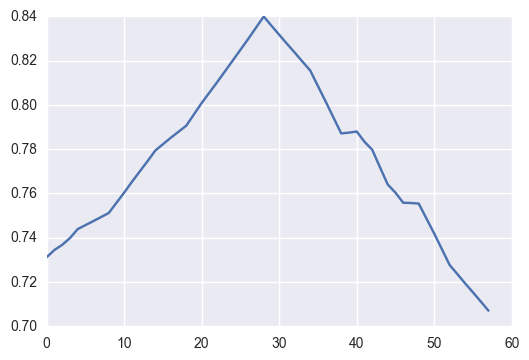

In [15]:
plt.plot(training_curve)

It shows the best scores is not in the non-overlapping scheme

Let's add mask to it

/Users/cicero/anaconda/envs/snakes/lib/python3.5/site-packages/healpy/fitsfunc.py:335: UserWarning: No INDXSCHM keyword in header file : assume IMPLICIT
  "assume {}".format(schm))
/Users/cicero/anaconda/envs/snakes/lib/python3.5/site-packages/numpy/core/numeric.py:190: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  a = empty(shape, dtype, order)


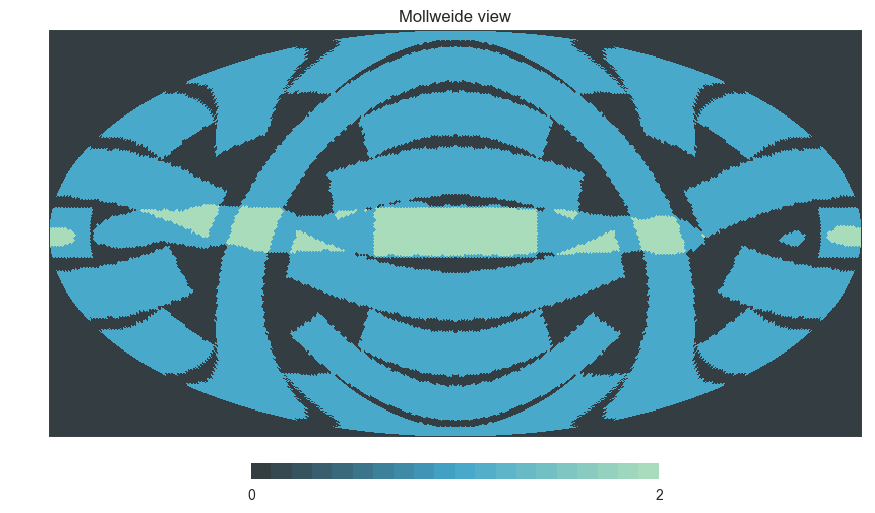

In [16]:
MK = True
map1 = hp.read_map('../Release2/HFI_Mask_GalPlane-apo0_2048_R2.00.fits', field=5, verbose=False)
mask_car = hp.cartview(map1, 
                       xsize=PATCH_SIZE * period , return_projected_map=True)
plt.close()
mask_car = 1 - mask_car
mask_car.astype(np.int64)
mask = mfun.cart_healpix(mask_car, NSIDE)
h, w       = opt_Layers.shape
opt_Layers = np.append(opt_Layers, mask).reshape(h + 1, w)
hp.mollview(np.sum(opt_Layers, axis=0), cmap=cmap1)

- `cart_healpix`: is a function to convert cartesian projection 2-D matrix into healpix array

...................Good_Scheme_Scores is 0.6550699869791666


/Users/cicero/anaconda/envs/snakes/lib/python3.5/site-packages/numpy/core/numeric.py:190: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  a = empty(shape, dtype, order)


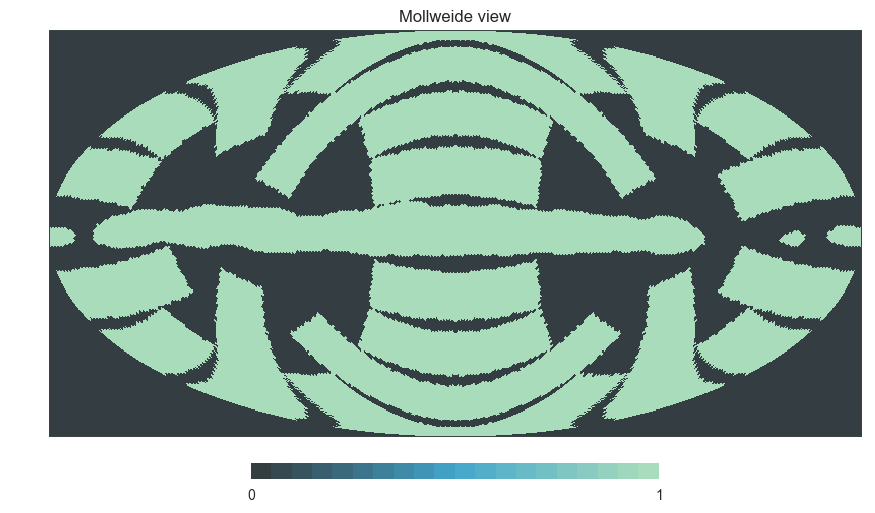

In [17]:
# Brute loop for optimization
opt_Layers, training_curve = Yakitori_optimize(opt_Layers, THETA_RANGE, PHI_RANGE, Mask=MK, snap=False)

## Interpret the Result
- use output `Layers` to extract reproducable list of positions 

How these functions work are not important

In [18]:
def Mind_Read_Layers(Layers, theta_range, phi_range, mask=False):
    survivors = [np.sum(A) for A in Layers]
    survivors_idx = np.nonzero(survivors)[0]
    
    # extract theta 
    Period = 360//phi_range
    theta_list = [S//Period for S in survivors_idx]
    
    # extract phi
    Height_element = 180//theta_range
    phi_list = [V%Period for V in survivors_idx]
    if mask==True:
        print('Mask option is open')
        theta_list = theta_list[:-1]
        phi_list = phi_list[:-1]
    return theta_list, phi_list

def Sort_Mind_Read_List(theta_list, phi_list):
    TSorted_list = []
    PSorted_list = []
    idx = [0] # Bad idea
    for i in range(len(theta_list)-1):
        if theta_list[i+1]!=theta_list[i]:
            idx.append(i+1)
    idx.append(len(theta_list)) # Bad idea
    
    for k in range(len(idx)-1):
        short_list = [theta_list[j] for j in range(idx[k],idx[k+1])]
        TSorted_list.append(short_list)
        short_list = [phi_list[j] for j in range(idx[k],idx[k+1])]
        PSorted_list.append(short_list)
    Height_List = [TSorted_list[i][0] for i in range(len(TSorted_list))]
    
    return Height_List, PSorted_list

theta_list, phi_list = Mind_Read_Layers(opt_Layers, THETA_RANGE, PHI_RANGE, mask = MK)
Height_List, PSorted_list = Sort_Mind_Read_List(theta_list, phi_list)
print('the list of chosen theta {}'.format(Height_List))
print('the list of chosen phi {}'.format(PSorted_list))

Mask option is open
the list of chosen theta [1, 2, 3, 4, 5, 6, 7]
the list of chosen phi [[0, 1, 2, 8, 9, 10, 11, 17, 18, 19], [0, 1, 8, 9, 10, 11, 18, 19], [0, 1, 2, 3, 6, 7, 8, 9, 10, 11, 12, 13, 16, 17, 18, 19], [0, 1, 8, 9, 10, 11, 18, 19], [0, 1, 2, 7, 8, 9, 10, 11, 12, 17, 18, 19], [0, 1, 8, 9, 10, 11, 18, 19], [0, 1, 8, 9, 10, 11, 12, 18, 19]]


Reconstruct the map

In [19]:
def CartView_Block_Rotater(theta, phi_range, 
                           nside, chosen_list, patch_size=30):
    ## patch_size should be even
    # Basic information of your painting
    period      = 360 // phi_range    
    canvas_size = period * patch_size
    
    # Generate a flat Healpix map
    Car_proj = np.zeros((canvas_size // 2, canvas_size))
    equator  = canvas_size // 4
    division_waist = np.arange(period) * patch_size

    for i in chosen_list:
        block = np.ones((patch_size, patch_size))
        
        Car_proj[equator - patch_size // 2 : equator + patch_size // 2, 
                 division_waist[i] : division_waist[i] + patch_size] \
            = Car_proj[equator - patch_size // 2 : equator + patch_size // 2, 
                       division_waist[i] : division_waist[i] + patch_size] \
            + block
                
    # cartview to healpix
    healpix_map = mfun.cart_healpix(Car_proj, nside)
    return mfun.healpix_rotate(healpix_map, (0, - theta))

/Users/cicero/anaconda/envs/snakes/lib/python3.5/site-packages/numpy/core/numeric.py:190: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  a = empty(shape, dtype, order)


0.0 180.0 -180.0 180.0
The interval between parallels is 20 deg 0.00'.
The interval between meridians is 20 deg 0.00'.


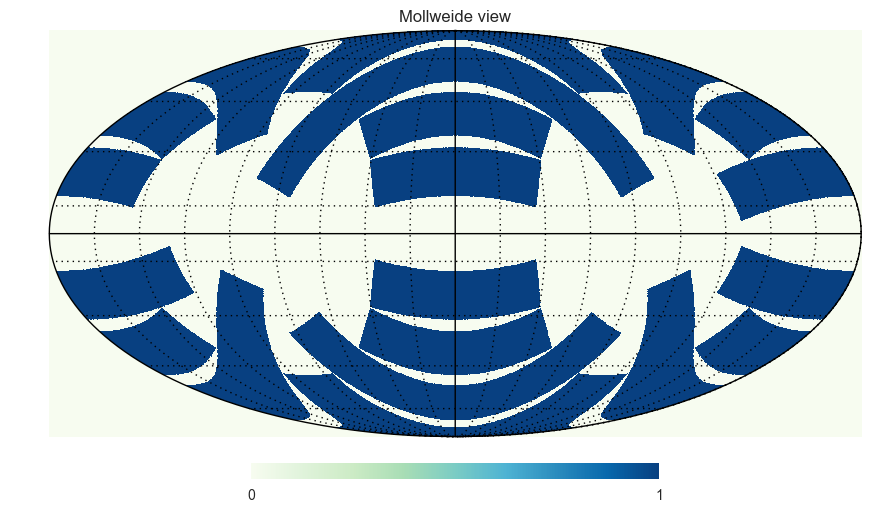

In [20]:
# Rotation Block Reconstruct
size  = 18
theta_size = 22.5
theta = Height_List
phi   = PSorted_list
nside = 512
Addition_healpix = np.zeros(hp.nside2npix(nside), dtype=np.double)

for T,P in zip(theta, phi):
    Addition_healpix += CartView_Block_Rotater(theta=T * theta_size, phi_range=size, nside=512, chosen_list=P, patch_size=240)
hp.mollview(Addition_healpix, xsize=5040, cmap='GnBu')
hp.graticule(coord='G', dpar=20, dmer=20)